In [1]:
import sys
sys.path.append('../..')

import numpy as np
from numpy.matlib import repmat
import pandas as pd
import eeg_decoder as eeg_decoder
import scipy.io as sio
import matplotlib.pyplot as plt
import seaborn as sns

from mne.filter import filter_data
from scipy.signal import hilbert, chirp

from collections import Counter
%load_ext autoreload
%autoreload 2

In [2]:
experiment_name = 'C01'
data_dir = f'./data/{experiment_name}'
exp = eeg_decoder.Experiment(experiment_name,data_dir,dev=False)
exp.behavior_files = sorted(list(exp.data_dir.glob('*behavior.csv')))

In [3]:
tois = np.arange(-200, 1001, 2)
times_bool = [1 if (t in tois) else 0 for t in exp.info['times']]
censor_times = exp.info['times'] > 1000 # values to convert to 0 to prevent leak backwards

In [4]:
time_window = 25
time_step = 25
trial_bin_size = 1 # not used
n_splits = 25
group_dict = {}

wrangl = eeg_decoder.Wrangler(tois,time_window,time_step,trial_bin_size,n_splits,group_dict)
wrangl.t

array([-200, -176, -152, -128, -104,  -80,  -56,  -32,   -8,   16,   40,
         64,   88,  112,  136,  160,  184,  208,  232,  256,  280,  304,
        328,  352,  376,  400,  424,  448,  472,  496,  520,  544,  568,
        592,  616,  640,  664,  688,  712,  736,  760,  784,  808,  832,
        856,  880,  904,  928,  952,  976])

In [5]:
palette = {
    'N1': 'royalblue',
    'H1': 'forestgreen',
    'L1': 'coral',
    '2': 'maroon'
}

# Helpers

In [6]:
def makeBlockAssignment_CommonTrain(nBlocks,nBins,posLabels,Cond1Idx,Cond2Idx):
    assert len(Cond1Idx)==len(Cond2Idx) and len(posLabels)==len(Cond1Idx)
    
    nTrials = len(Cond1Idx); 
    blocks = np.full((nTrials), np.nan)
    
    C1_posLabels = posLabels[Cond1Idx]
    C2_posLabels = posLabels[Cond2Idx]
    
    binCnt = np.full((2, nBins), np.nan)
    for b in range(nBins):
        binCnt[0,b] = np.sum(C1_posLabels == b+1)
        binCnt[1,b] = np.sum(C2_posLabels == b+1)

    minCnt = np.min(binCnt)
    nPerBin = int(np.floor(minCnt/nBlocks))
    
    
    for c in [1, 2]:
        pBin = C1_posLabels if c==1 else C2_posLabels

        tmp_nTrials = len(pBin)
        shuffBlocks = np.full(pBin.shape, np.nan)

        # shuffle trials
        shuffInd = np.arange(tmp_nTrials)
        np.random.shuffle(shuffInd)
        shuffBin = pBin[shuffInd] # shuffle trial order

        # take the 1st nPerBin x nBlocks trials for each position bin.
        for b in range(nBins):
            idx = np.where(shuffBin == b+1)[0]  # get index for trials belonging to the current bin
            idx = idx[:nPerBin*nBlocks]  # drop excess trials
            x = repmat(np.arange(1, nBlocks+1), 1, nPerBin)
            shuffBlocks[idx] = x # assign trials to blocks

        if c==1:
            C1_Blocks = np.full(C1_posLabels.shape, np.nan)
            C1_Blocks[shuffInd] = shuffBlocks
        elif c==2:
            C2_Blocks = np.full(C2_posLabels.shape, np.nan)
            C2_Blocks[shuffInd] = shuffBlocks


    ## regular blocks is just two condLabels combined
    blocks[Cond1Idx] = C1_Blocks
    blocks[Cond2Idx] = C2_Blocks
    nTrialsPerBlock = np.sum(blocks==1) # of trials per block
    nTrialsPerBlock_C1 = np.sum(blocks[Cond1Idx]==1)
    nTrialsPerBlock_C2 = np.sum(blocks[Cond2Idx]==1)
    
    return(blocks, nTrialsPerBlock, nTrialsPerBlock_C1, nTrialsPerBlock_C2)

In [7]:
def MakeCircularBasis_Even_Bins(nBins, nChans, sinPower, x):
    prediction = np.sin(0.5*x)**sinPower
    prediction = np.roll(prediction, 4, axis=0)
    basisSet = np.full((nChans, nBins), np.nan)
    basisSet[0, :] = prediction
    for c in range(1, nChans):
        basisSet[c, :] = prediction = np.roll(prediction, 1, axis=0)
    return(basisSet)

In [8]:
def MakeDeltaBasis_Square(nBins, nChans):
    
    assert nBins==nChans # for this sudy, we are using 4 and 4
    return(np.eye(nBins, nChans))
    

In [9]:
def sort_and_mean_CTF(ctf, shuffle=False): 
    # these are the quadrants
    #########
    # 0 # 1 #
    #########
    # 3 # 2 #
    #########
    # the channels for each bin get resorted to be 0=bin, 1=adjacent same hemi, 2=adjacent cross hemi, 3=diagonal
    
    bin_idx = [0, 1, 2, 3]
    if shuffle:
        bin_idx = np.random.permutation(bin_idx) # shuffle how each bin is treated

    ctf[bin_idx[0], :] = ctf[bin_idx[0], [0, 3, 1, 2]]
    ctf[bin_idx[1], :] = ctf[bin_idx[1], [1, 2, 0, 3]]
    ctf[bin_idx[2], :] = ctf[bin_idx[2], [2, 1, 3, 0]]
    ctf[bin_idx[3], :] = ctf[bin_idx[3], [3, 0, 2, 1]]
    
    return np.mean(ctf, 0) # mean across bins

def CTF_Slope(ctf):
    x = [1, 2, 3]
    y = [ctf[0], ctf[[1,2]].mean(), ctf[3]]
    return(np.polyfit(x, y, deg=1)[0]) # fit and get slope

In [10]:
def IEM_2cond(totalPower, posLabels, condLabels, times_bool, sinPower=25, nBins=4, nChans=4, nIter=25, nBlocks=3, freq_bounds=[8, 12], time = tois, Fs=500, wrangl=wrangl):
    # ARGUMENTS
    # totalPower = alpha power of EEG data of shape nTrials, nElectrodes, nTimePoints
    # posLabels = list of spatial positions (in terms of bin number) for each trial
    # condLabels = list of condition labels (1 or 2) for each trial
    # sinPower = power of the response function 
    # nBins = num location bins
    # nChans = num channels (cell popluations)
    # nIter =  num iterations (input to function)
    # nBlocks = num blocks for cross-validation
    # freq_bounds = frequency range to analyze 
    # nSamps = num time points of interest
    # Fs = Sampling rate of EEG

    nSamps = len(time)
    nTrials = len(posLabels)
    nElectrodes = totalPower.shape[1]
    
    x = np.linspace(0, 2*np.pi-2*np.pi/nBins, nBins)
    basisSet = MakeDeltaBasis_Square(nBins, nChans)
    
    Cond1Idx = condLabels==1
    Cond2Idx = condLabels==2
    
    # Preallocate Output Matrices
    tf_total_Cond1 = np.full((nIter,len(wrangl.t),nBlocks,nChans), np.nan)
    tf_total_Cond2 = np.full((nIter,len(wrangl.t),nBlocks,nChans), np.nan)
    tf_total_Cond1_shuff = np.full((nIter,len(wrangl.t),nBlocks,nChans), np.nan)
    tf_total_Cond2_shuff = np.full((nIter,len(wrangl.t),nBlocks,nChans), np.nan)
    
    sl_total_Cond1 = np.full((nIter,len(wrangl.t),nBlocks), np.nan)
    sl_total_Cond2 = np.full((nIter,len(wrangl.t),nBlocks), np.nan)
    sl_total_Cond1_shuff = np.full((nIter,len(wrangl.t),nBlocks), np.nan)
    sl_total_Cond2_shuff = np.full((nIter,len(wrangl.t),nBlocks), np.nan)
    
    blocks = np.full((nTrials,nIter), np.nan)
    
    ## Filter and Organize Data into Blocks
    totalPower = np.squeeze(totalPower[:, :, np.where(times_bool)]) # subset to times-of-interest
    assert totalPower.shape[2]==nSamps
    
    ## create block assignments
    for i in range(nIter):
        (curr_blocks, nTrialsPerBlock, nTrialsPerBlock_C1, nTrialsPerBlock_C2) = makeBlockAssignment_CommonTrain(nBlocks,nBins,posLabels,Cond1Idx,Cond2Idx);
        blocks[:,i] = curr_blocks
        
    tmpBlocks = blocks.copy()
    
    for i in range(nIter):
        curr_blocks = tmpBlocks[:,i]
        
        # Preallocate
        blockDat_total = np.full((nBins*nBlocks, nElectrodes, nSamps), np.nan)
        blockDat_total_Cond1 = np.full((nBins*nBlocks, nElectrodes, nSamps), np.nan)
        blockDat_total_Cond2 = np.full((nBins*nBlocks, nElectrodes, nSamps), np.nan)

        labels = np.full((nBins*nBlocks), np.nan)
        blockNum = np.full((nBins*nBlocks), np.nan)
        c = np.full((nBins*nBlocks, nChans), np.nan)

        # Average data for each bin across blocks
        counter = 0
        for j in range(nBins):
            for k in range(nBlocks):
                # all data for training
                blockDat_total[counter,:,:] = np.mean(totalPower[(posLabels==j+1) & (curr_blocks==(k+1)),:,:],0)
                # Cond1 Test
                blockDat_total_Cond1[counter,:,:] = np.mean(totalPower[(Cond1Idx) & (posLabels==j+1) & (curr_blocks==(k+1)),:,:],0)
                # Cond2 Test
                blockDat_total_Cond2[counter,:,:] = np.mean(totalPower[(Cond2Idx) & (posLabels==j+1) & (curr_blocks==(k+1)),:,:],0)

                # info
                labels[counter] = j
                blockNum[counter] = k
                c[counter,:] = basisSet[j,:]
                counter+=1

        # run IEM on each timepoint
        for t in range(len(wrangl.t)):
            time_window_idx = (wrangl.samples >= wrangl.t[t]) & (
                wrangl.samples < wrangl.t[t] + wrangl.time_window)
            
            dt = np.mean(blockDat_total[:, :, time_window_idx], 2)
            dt_Cond1 = np.mean(blockDat_total_Cond1[:,:,time_window_idx], 2)
            dt_Cond2 = np.mean(blockDat_total_Cond2[:,:,time_window_idx], 2)

            for b in range(nBlocks): # hold out each block as the test set, train on the other 2
                train_labels = labels[blockNum!=b]
                test_labels = labels[blockNum==b]

                C1 = c[blockNum!=b, :]
                B1 = dt[blockNum!=b, :]
                B2_Cond1 = dt_Cond1[blockNum==b, :]
                B2_Cond2 = dt_Cond2[blockNum==b, :]

                # fit model and record res
                channel_weights = np.linalg.lstsq(C1, B1, rcond=None)[0]
                
                recon1 = np.linalg.lstsq(channel_weights.T , B2_Cond1.T, rcond=None)[0].T
                CTF_C1 = sort_and_mean_CTF(recon1);
                CTF_C1_shuff = sort_and_mean_CTF(recon1, shuffle=True)
                
                recon2 = np.linalg.lstsq(channel_weights.T , B2_Cond2.T, rcond=None)[0].T
                CTF_C2 = sort_and_mean_CTF(recon2);
                CTF_C2_shuff = sort_and_mean_CTF(recon2, shuffle=True)
                
                
                # record CTFs
                tf_total_Cond1[i,t,b,:] = CTF_C1
                tf_total_Cond1_shuff[i,t,b,:] = CTF_C1_shuff
                tf_total_Cond2[i,t,b,:] = CTF_C2
                tf_total_Cond2_shuff[i,t,b,:] = CTF_C2_shuff
                
                # record slopes
                sl_total_Cond1[i,t,b] = CTF_Slope(CTF_C1)
                sl_total_Cond1_shuff[i,t,b] = CTF_Slope(CTF_C1_shuff)
                sl_total_Cond2[i,t,b] = CTF_Slope(CTF_C2)
                sl_total_Cond2_shuff[i,t,b] = CTF_Slope(CTF_C2_shuff)

                
    return {
        'CTFs': {
            'Cond1': tf_total_Cond1,
            'Cond1_shuff': tf_total_Cond1_shuff,
            'Cond2': tf_total_Cond2,
            'Cond2_shuff': tf_total_Cond2_shuff,
        },
        'slopes': {
            'Cond1': sl_total_Cond1,
            'Cond1_shuff': sl_total_Cond1_shuff,
            'Cond2': sl_total_Cond2,
            'Cond2_shuff': sl_total_Cond2_shuff,
        }
    }

# setup and clean up data

In [11]:
def get_second_bin(bin_str):
    try:
        return int(bin_str[4])
    except:
        return np.nan

In [ ]:
xdata_dict = {}
behavior_dict = {}

for isub in range(exp.nsub):
    print(isub)
    xdata,ydata = exp.load_eeg(isub)
    xdata[:,:,censor_times] = 0 # censor timepoints to prevent bleeding backwards

    noArt_idx = exp.load_artifact_idx(isub)
    assert xdata.shape[0]==noArt_idx.sum()

    behavior = pd.read_csv(exp.behavior_files[isub])
    behavior = behavior[behavior.Block.notnull()] # cut out original post-task stuff
    
    if len(behavior)!=noArt_idx.shape[0]:
        print(f'error on isub {isub}; won\'t be included')
        continue
        
    behavior = behavior.loc[noArt_idx, :].reset_index(drop=True)
    assert len(behavior)==xdata.shape[0]

    behavior['Bin'] = behavior.Quadrants.apply(lambda x: int(x[1])).values
    behavior['OtherBin'] = behavior.Quadrants.apply(get_second_bin).values
    
    xdata_dict[isub] = np.abs(hilbert(filter_data(xdata.astype(np.float64), 500, 8, 12)))**2 # convert to total alpha power
    behavior_dict[isub] = behavior

In [13]:
def make_CTF_df(results_dict, isub, cond, condname, wrangl=wrangl, t=200):
    sub_CTFs = pd.DataFrame()
    # mean across iterations, blocks, ignore the first 500ms before meaning across time
    sub_CTFs['Response'] = results_dict[isub]['CTFs'][cond].mean(0).mean(1)[wrangl.t > t, :].mean(0)
    sub_CTFs['Channel'] = np.arange(1,5)
    sub_CTFs['PID'] = isub
    sub_CTFs['condition'] = condname
    return(sub_CTFs)

In [14]:
def make_slope_df(results, isub, cond, condname, time=wrangl.t):
    sub_slopes = pd.DataFrame()
    sub_slopes['time'] = time
    sub_slopes['Slope'] = results[isub]['slopes'][cond].mean(0).mean(1)
    sub_slopes['PID'] = isub
    sub_slopes['condition'] = condname
    return(sub_slopes)

## Pipeline

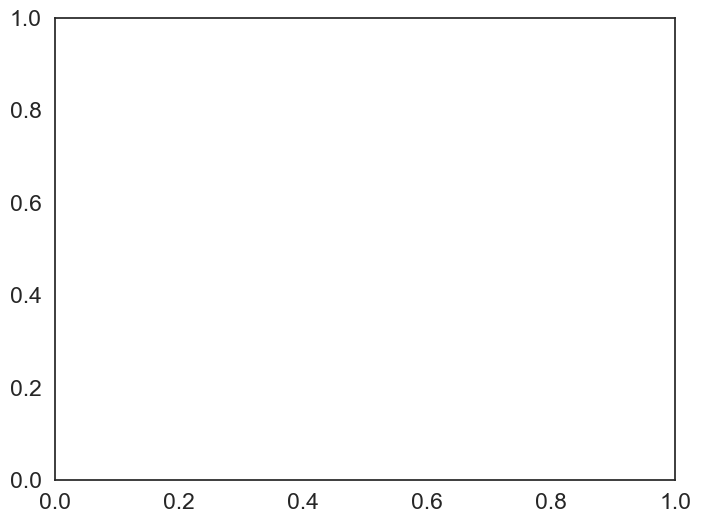

In [15]:
sns.set_theme(font_scale=1.5,style='white')
plt.subplots(figsize=(8,6))
palette = ['forestgreen', 'orange']

In [16]:
def compare_two_conds(low, high, xdata_dict=xdata_dict, behavior_dift=behavior_dict, bin_col='Bin'):
    cond_map = {
        low: 1,
        high: 2
    }
    
    IEM_results = {}

    for isub in xdata_dict:
        xdata = xdata_dict[isub]
        behavior = behavior_dict[isub]

        subset_idx = behavior.BlockCondition.isin([low, high])

        xdata = xdata[subset_idx]
        posLabels = behavior.loc[subset_idx, bin_col].values + 1 # shift from 0-3 to 1-4
        condLabels = behavior.loc[subset_idx, 'BlockCondition'].values

        condLabels = np.array(list(map(cond_map.get, condLabels))) # convert to 1s and 2s

        print(isub, Counter(condLabels))

        IEM_results[isub] = IEM_2cond(xdata, posLabels, condLabels, times_bool)
        
    # plot slope results
    slope_df = pd.DataFrame()
    for isub in IEM_results:
        sub_slopes_obs = pd.concat([make_slope_df(IEM_results, isub, 'Cond1', low),
               make_slope_df(IEM_results, isub, 'Cond2', high)])
        sub_slopes_obs['method'] = 'Observed'

        sub_slopes_shuff = pd.concat([make_slope_df(IEM_results, isub, 'Cond1_shuff', low),
               make_slope_df(IEM_results, isub, 'Cond2_shuff', high)])
        sub_slopes_shuff['method'] = 'Shuffled'

        slope_df = pd.concat([slope_df, sub_slopes_obs, sub_slopes_shuff])

    slope_df = slope_df.reset_index(drop=True)
    
    # _ = sns.lineplot(x='time', y='Slope', hue='condition', style='method', data=slope_df, palette=palette)
    # _ = plt.axhline(y=0, color='k', linestyle='--', linewidth=3)
    # plt.show()
    # plt.close()
    
    # plot CTF reconstructed 
    CTF_df = pd.DataFrame()
    for isub in IEM_results:
        sub_CTFs_obs = pd.concat([make_CTF_df(IEM_results, isub, 'Cond1', low),
               make_CTF_df(IEM_results, isub, 'Cond2', high)])
        sub_CTFs_obs['method'] = 'Observed'

        sub_CTFs_shuff = pd.concat([make_CTF_df(IEM_results, isub, 'Cond1_shuff', low),
               make_CTF_df(IEM_results, isub, 'Cond2_shuff', high)])
        sub_CTFs_shuff['method'] = 'Shuffled'


        CTF_df = pd.concat([CTF_df, sub_CTFs_obs, sub_CTFs_shuff])

    CTF_df = CTF_df.reset_index(drop=True)

    return CTF_df,slope_df

# New IEM

In [22]:
_,slope_n1_target = compare_two_conds('N1', '2', bin_col='Bin')
_,slope_h1_target = compare_two_conds('H1', '2', bin_col='Bin')
_,slope_h1_dist = compare_two_conds('H1', '2', bin_col='OtherBin')
_,slope_l1_target = compare_two_conds('L1', '2', bin_col='Bin')
_,slope_l1_dist = compare_two_conds('L1', '2', bin_col='OtherBin')

0 Counter({2: 282, 1: 272})
1 Counter({2: 266, 1: 254})
2 Counter({1: 211, 2: 189})
3 Counter({2: 195, 1: 186})
4 Counter({2: 265, 1: 222})
5 Counter({2: 257, 1: 194})
6 Counter({2: 243, 1: 188})
7 Counter({2: 225, 1: 186})
8 Counter({2: 274, 1: 243})
9 Counter({1: 241, 2: 211})
10 Counter({1: 245, 2: 226})
11 Counter({1: 274, 2: 273})
12 Counter({1: 240, 2: 224})
13 Counter({1: 252, 2: 248})
14 Counter({1: 276, 2: 233})
15 Counter({2: 273, 1: 268})
16 Counter({2: 288, 1: 286})
17 Counter({1: 186, 2: 165})
18 Counter({2: 229, 1: 218})
19 Counter({1: 234, 2: 231})
20 Counter({2: 229, 1: 206})
21 Counter({2: 248, 1: 234})
0 Counter({1: 283, 2: 282})
1 Counter({2: 266, 1: 242})
2 Counter({1: 227, 2: 189})
3 Counter({2: 195, 1: 191})
4 Counter({2: 265, 1: 222})
5 Counter({1: 268, 2: 257})
6 Counter({1: 243, 2: 243})
7 Counter({2: 225, 1: 205})
8 Counter({2: 274, 1: 251})
9 Counter({1: 232, 2: 211})
10 Counter({1: 260, 2: 226})
11 Counter({1: 274, 2: 273})
12 Counter({1: 228, 2: 224})
13 Co

In [59]:
def concat(dfa,dfb,string):
    
    target = dfa.query(f'condition=="{string}"').reset_index()
    dist = dfb.query(f'condition=="{string}"').reset_index()
    target['Target'] = 'target'
    dist['Target'] = 'distractor'
    return pd.concat([target,dist])

In [60]:
x_h1 = concat(slope_h1_target,slope_h1_dist,'H1')
x_l1 = concat(slope_l1_target,slope_l1_dist,'L1')
x_ss2 = concat(slope_h1_target,slope_h1_dist,'2')
x_n1 = slope_n1_target.query(f'condition=="N1"').reset_index()

In [61]:
x_h1['ss'] = 1
x_n1['ss'] = 1
x_l1['ss'] = 1
x_ss2['ss'] = 2
x_ss2['Target'] = 'target'
x_n1['Target'] = 'target'

In [63]:
x_all = pd.concat([x_n1,x_h1,x_l1,x_ss2]).query('method=="Observed"').reset_index()
x_all.Slope *= -1

In [64]:
x_all.to_csv('output/iems_new.csv')

In [65]:
x_all = pd.read_csv('output/iems_new.csv')
x_all = x_all.drop(['Unnamed: 0','level_0','index'],axis=1)
x_all.head()

,time,Slope,PID,condition,method,ss,Target
0,-200,-0.191043,0,N1,Observed,1,target
1,-176,-0.160354,0,N1,Observed,1,target
2,-152,-0.027019,0,N1,Observed,1,target
3,-128,0.162051,0,N1,Observed,1,target
4,-104,0.277014,0,N1,Observed,1,target


In [91]:
def cond_label(row):
    if (row['condition']) == 'N1':
        return 'ss1_solo_target'
    elif (row['Target'] == 'target') & (row['ss'] == 1):
        return 'ss1_target'
    elif row['ss'] == '2':
        return 'ss2_target'
    else:
        return f'{row["Target"]}_{row["condition"]}'
x_all['label'] = x_all.apply(cond_label,axis=1)
x_all.head()

,time,Slope,PID,condition,method,ss,Target,label,label_all,Time
0,-200,-0.191043,0,N1,Observed,1,target,ss1_solo_target,target_N1,Pre
1,-176,-0.160354,0,N1,Observed,1,target,ss1_solo_target,target_N1,Pre
2,-152,-0.027019,0,N1,Observed,1,target,ss1_solo_target,target_N1,Pre
3,-128,0.162051,0,N1,Observed,1,target,ss1_solo_target,target_N1,Pre
4,-104,0.277014,0,N1,Observed,1,target,ss1_solo_target,target_N1,Pre


In [92]:
x_all.label.unique()

array(['ss1_solo_target', 'ss1_target', 'distractor_H1', 'distractor_L1',
       'target_2'], dtype=object)

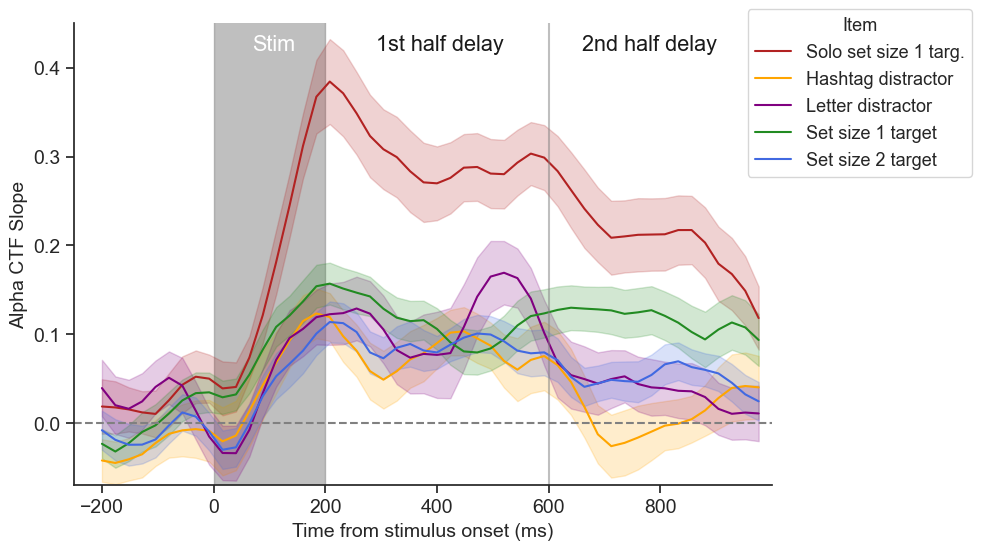

In [103]:
plt.close()
colors = ['firebrick', 'orange','purple','forestgreen','royalblue']

fig,ax =plt.subplots(figsize=(9,6))
ax.fill_between([0,200], [-1, -1], [
                1, 1], color='gray', alpha=.5)
sns.lineplot(data=x_all,x='time',y='Slope',hue='label',ax=ax,legend=True,errorbar='se',
             palette=colors, hue_order=['ss1_solo_target','distractor_H1','distractor_L1','ss1_target','target_2'])
ax.axhline(y=0, color='grey', linestyle='--')
ax.axvline(x=600, color='grey', alpha=.5,linestyle='-')

# aesthetics
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.set_xlabel('Time from stimulus onset (ms)',fontsize=14)
ax.set_ylabel('Alpha CTF Slope',fontsize=14)
plt.setp(ax.get_xticklabels(), fontsize=14)
plt.setp(ax.get_yticklabels(), fontsize=14)
plt.ylim(-.07,.45)
plt.xlim(-250,999)
ax.text(68,.42,'Stim',color='w')
ax.text(290,.42,'1st half delay',color='k')
ax.text(660,.42,'2nd half delay',color='k')

leg = ax.legend(title='Item',fontsize=13,bbox_to_anchor=(1.3, 1.05))
labels=['Solo set size 1 targ.','Hashtag distractor','Letter distractor','Set size 1 target','Set size 2 target']
for i,l in enumerate(leg.get_texts()):
    l.set_text(labels[i])
plt.setp(leg.get_title(),fontsize=13)

plt.savefig('output/figures/iem_new_legend.png',dpi=500,bbox_inches='tight')
plt.savefig('output/figures/iem_new_legend.pdf',dpi=500,bbox_inches='tight')
plt.show()

In [76]:
x_all['label_all'] = x_all.apply(lambda x: f'{x["Target"]}_{x["condition"]}',axis=1)

In [77]:
label = []
def assign_timebin(row):
    if row['time']<0:
        return 'Pre'
    elif (row['time']<200):
        return 'Stim'
    elif (row['time']>200) & (row['time'] < 600):
        return 'First half'
    else:
        return 'Second half'
x_all['Time'] = x_all.apply(assign_timebin,axis=1)

In [78]:
x_all

,time,Slope,PID,condition,method,ss,Target,label,label_all,Time
0,-200,-0.191043,0,N1,Observed,1,target,ss1_target,target_N1,Pre
1,-176,-0.160354,0,N1,Observed,1,target,ss1_target,target_N1,Pre
2,-152,-0.027019,0,N1,Observed,1,target,ss1_target,target_N1,Pre
3,-128,0.162051,0,N1,Observed,1,target,ss1_target,target_N1,Pre
4,-104,0.277014,0,N1,Observed,1,target,ss1_target,target_N1,Pre
...,...,...,...,...,...,...,...,...,...,...
7695,880,0.041390,21,2,Observed,2,target,target_2,target_2,Second half
7696,904,0.014669,21,2,Observed,2,target,target_2,target_2,Second half
7697,928,0.081718,21,2,Observed,2,target,target_2,target_2,Second half
7698,952,0.168042,21,2,Observed,2,target,target_2,target_2,Second half


In [80]:
subject_means = x_all.drop(['method','label','label_all'],axis=1).groupby(['PID','condition','Target','Time']).mean().reset_index().rename(columns={'condition':'Condition','label_all':'Label'})

In [81]:
subject_means

,PID,Condition,Target,Time,time,Slope,ss
0,0,2,target,First half,400.0,0.198111,2.0
1,0,2,target,Pre,-104.0,-0.036424,2.0
2,0,2,target,Second half,796.0,0.209168,2.0
3,0,2,target,Stim,100.0,0.171030,2.0
4,0,H1,distractor,First half,400.0,0.124979,1.0
...,...,...,...,...,...,...,...
523,21,L1,target,Stim,100.0,0.001353,1.0
524,21,N1,target,First half,400.0,0.279394,1.0
525,21,N1,target,Pre,-104.0,-0.070909,1.0
526,21,N1,target,Second half,796.0,0.198493,1.0


C:\Users\William\AppData\Local\Temp\ipykernel_13388\2436195958.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_yticklabels([''])
C:\Users\William\AppData\Local\Temp\ipykernel_13388\2436195958.py:51: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[2].set_yticklabels([''])


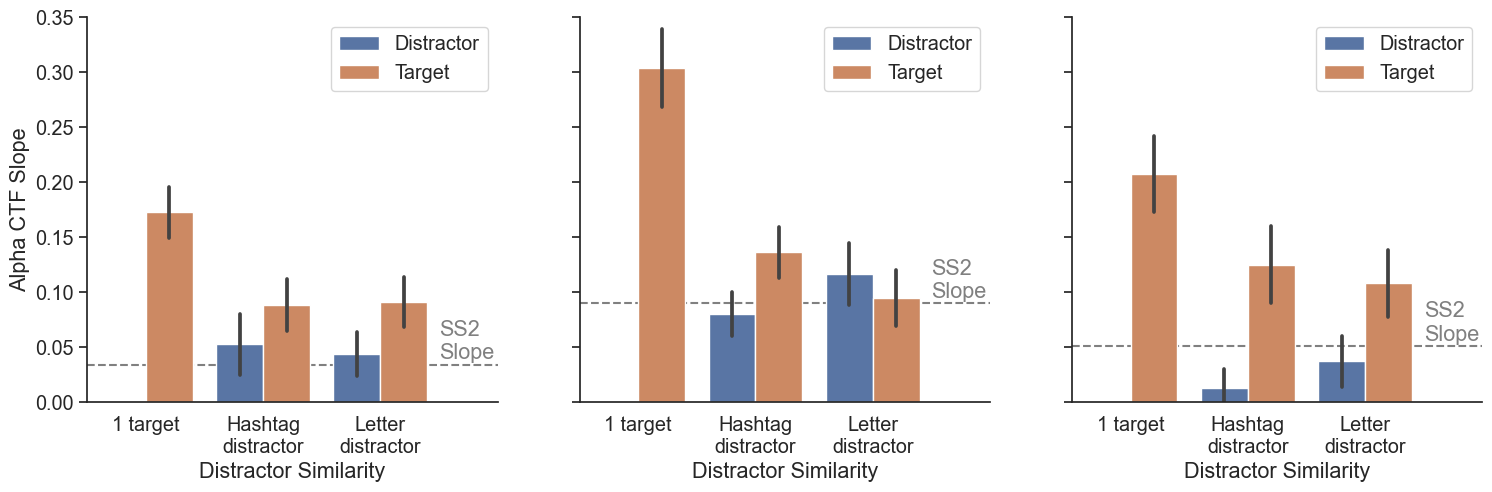

In [85]:
import seaborn as sns
import matplotlib.pyplot as plt

custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(font_scale=1.3,style='white',rc=custom_params)
fig,ax = plt.subplots(1,3,figsize=(18,5))

sns.barplot(
    x='Condition',y='Slope', hue='Target',
    data=subject_means.query('(Time=="Stim")&(Condition!="2")'),ax=ax[0],
    errorbar='se',
    order=['N1','H1','L1'],
    dodge=True)
ss2_slope = subject_means.query('(Time=="Stim")&(Condition=="2")')['Slope'].mean()
ax[0].axhline(
    y=ss2_slope,
    linestyle='--',color='gray',zorder=-1)
ax[0].text(x=2.5,y = ss2_slope+.005, s='SS2\nSlope',color='gray')
ax[0].set_ylabel('Alpha CTF Slope')
ax[0].yaxis.set_ticks_position('left')

# First half
sns.barplot(
    x='Condition',y='Slope', hue='Target',
    data=subject_means.query('(Time=="First half")&(Condition!="2")'),ax=ax[1],#palette= colors,
    errorbar='se',
    order=['N1','H1','L1'],
    dodge=True)
ss2_slope = subject_means.query('(Time=="First half")&(Condition=="2")')['Slope'].mean()
ax[1].axhline(
    y=ss2_slope,
    linestyle='--',color='gray',zorder=-1)
ax[1].text(x=2.5,y = ss2_slope+.005, s='SS2\nSlope',color='gray')
ax[1].yaxis.set_ticks_position('left')
ax[1].set_yticklabels([''])
ax[1].set_ylabel('')

# second half
sns.barplot(
    x='Condition',y='Slope', hue='Target',
    data=subject_means.query('(Time=="Second half")&(Condition!="2")'),ax=ax[2],#palette= colors,
    order=['N1','H1','L1'],
    errorbar='se',
    dodge=True)
ss2_slope = subject_means.query('(Time=="Second half")&(Condition=="2")')['Slope'].mean()
ax[2].axhline(
    y=ss2_slope,
    linestyle='--',color='gray',zorder=-1)
ax[2].text(x=2.5,y = ss2_slope+.005, s='SS2\nSlope',color='gray')
ax[2].yaxis.set_ticks_position('left')
ax[2].set_yticklabels([''])
ax[2].set_ylabel('')

for a in ax:
    a.set_ylim(0,.35)
    a.set_xticklabels(['1 target','Hashtag\ndistractor','Letter\ndistractor'])
    leg = a.get_legend()
    leg.set_title("")
    leg.get_texts()[0].set_text('Distractor')
    leg.get_texts()[1].set_text('Target')
    a.set_xlim(-.5,3)
    a.set_xlabel('Distractor Similarity')

plt.savefig('output/figures/iembar.png',dpi=500,bbox_inches='tight')
plt.savefig('output/figures/iembar.pdf',dpi=500,bbox_inches='tight')
plt.show()

In [86]:
subject_means.groupby(['Condition','Target','Time']).agg(['mean','std'])['Slope']

mean       std
Condition Target     Time                           
2         target     First half   0.090139  0.091064
                     Pre         -0.009688  0.063585
                     Second half  0.051313  0.076964
                     Stim         0.034217  0.072927
H1        distractor First half   0.080492  0.093677
                     Pre         -0.024594  0.081649
                     Second half  0.012948  0.082556
                     Stim         0.052531  0.129774
          target     First half   0.136127  0.108844
                     Pre         -0.000426  0.113402
                     Second half  0.124969  0.163386
                     Stim         0.088366  0.109006
L1        distractor First half   0.116579  0.130494
                     Pre          0.025818  0.110849
                     Second half  0.036971  0.110746
                     Stim         0.043778  0.092673
          target     First half   0.094942  0.119085
                     Pre          0.003522  0.109445
                     Second half  0.108191  0.142999
                     Stim         0.091234  0.106888
N1        target     First half   0.303924  0.165927
                     Pre          0.027194  0.089675
                     Second half  0.207312  0.161933
                     Stim         0.172465  0.108023

In [90]:
from statsmodels.formula.api import ols
import statsmodels.api as sm

model_stim = ols('Slope ~ C(Condition) + C(Target) + C(Condition)*C(Target)', data=subject_means.loc[subject_means['Time']=='Stim']).fit();
anova_table_stim = sm.stats.anova_lm(model_stim, typ=1);
anova_table_stim

,df,sum_sq,mean_sq,F,PR(>F)
C(Condition),3.0,0.245066,0.081689,7.457386,0.000123
C(Target),1.0,0.038156,0.038156,3.483293,0.064316
C(Condition):C(Target),3.0,0.027378,0.009126,0.833105,0.478077
Residual,126.0,1.380213,0.010954,NaN,NaN


In [88]:
model_first = ols('Slope ~ C(Condition) + C(Target) + C(Condition)*C(Target)', data=subject_means.loc[subject_means['Time']=='First half']).fit();
anova_table_first = sm.stats.anova_lm(model_first, typ=1);
anova_table_first

,df,sum_sq,mean_sq,F,PR(>F)
C(Condition),3.0,0.740470,0.246823,16.894743,2.764535e-09
C(Target),1.0,0.006357,0.006357,0.435105,5.106985e-01
C(Condition):C(Target),3.0,0.040260,0.013420,0.918587,4.340062e-01
Residual,126.0,1.840793,0.014609,NaN,NaN


In [89]:
model_second = ols('Slope ~ C(Condition) + C(Target) + C(Condition)*C(Target)', data=subject_means.loc[subject_means['Time']=='Second half']).fit();
anova_table_second = sm.stats.anova_lm(model_second, typ=1);
anova_table_second

,df,sum_sq,mean_sq,F,PR(>F)
C(Condition),3.0,0.368515,0.122838,7.492450,0.000118
C(Target),1.0,0.184676,0.184676,11.264237,0.001045
C(Condition):C(Target),3.0,0.016851,0.005617,0.342609,0.794549
Residual,126.0,2.065761,0.016395,NaN,NaN
